In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import numpy as np
from PIL import Image

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

import ssl

import matplotlib.pyplot as plt

In [2]:
os.chdir("..")
ssl._create_default_https_context = ssl._create_unverified_context

In [18]:
PATCH_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
N_EPOCHS = 30
N_WORKERS = 10
MODELS_PATH = "models/classification"
TARGET_NAMES = ["Normal", "COVID", "Lung_Opacity", "Viral_Pneumonia"]
N_CLASSES = len(TARGET_NAMES)

In [4]:
class Covid19Dataset(Dataset):
    def __init__(self, image_paths, labels):
        """
        image_paths: Lista de caminhos das imagens.
        labels: Lista das respectivas classes das imagens.
        """
        self.image_paths = image_paths
        self.labels = labels
        # Default transform
        self.transform = transforms.Compose(
            [
                transforms.Resize(PATCH_SIZE),
                transforms.ToTensor(),
            ]
        )


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Carrega a imagem
        image = Image.open(img_path).convert("RGB")

        image = self.transform(image)

        return image, label
    
    def set_transform(self, transform):
        self.transform = transform


In [5]:
from sklearn.model_selection import train_test_split

data_dir = "data/raw"

all_image_paths = []
all_labels = []

for i, class_name in enumerate(TARGET_NAMES):
    class_dir = os.path.join(data_dir, class_name)
    images_dir = os.path.join(class_dir, "images")
    images_names = sorted(os.listdir(images_dir))

    for img_name in images_names[:250]:
        img_path = os.path.join(images_dir, img_name)
        all_image_paths.append(img_path)
        all_labels.append(i)

train_images, test_images, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

In [6]:
train_dataset = Covid19Dataset(train_images, train_labels)
test_dataset = Covid19Dataset(test_images, test_labels)

In [7]:
def train_model(model, train_loader, criterion, optimizer, n_epochs):
    model.train() 

    for epoch in range(n_epochs):        
        running_loss = 0.0
        running_corrects = 0
        
        # Treinamento
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Epoch {epoch+1}/{n_epochs} / Loss: {epoch_loss:.4f} / Acc: {epoch_acc:.4f}')
        print('-' * 40)


In [8]:
def evaluate_model(model, test_loader, target_names):
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calcular tempo de execução
    elapsed_time = time.time() - start_time
    print(f"Tempo de teste: {elapsed_time:.2f} segundos")

    # Calcular métricas globais
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    global_f1 = f1_score(all_labels, all_preds, average="weighted")
    global_acc = accuracy_score(all_labels, all_preds)

    print(f"Global F1-score: {global_f1:.4f}")
    print(f"Global Accuracy: {global_acc:.4f}")

    # F1-score por classe
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    print(f"F1-score por classe: {f1_per_class}")

    # Preparando os gráficos

    num_classes = len(target_names)

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

    # Figura para a matriz de confusão
    plt.figure(figsize=(10, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Matriz de Confusão', fontdict={"fontweight": "bold"})
    plt.xlabel('Real', fontdict={"fontweight": "bold"})
    plt.ylabel('Predito', fontdict={"fontweight": "bold"})
    plt.xticks(rotation=45)
    plt.show()

    # Curvas ROC e AUC por classe
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))  # Binarizar labels
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8, 6))  # Figura separada para as curvas ROC
    for i, target_name in enumerate(target_names):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{target_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo', fontdict={"fontweight": "bold"})
    plt.ylabel('Verdadeiro Positivo', fontdict={"fontweight": "bold"})
    plt.title('Curva ROC Multiclasse', fontdict={"fontweight": "bold"})
    plt.legend(loc='lower right')
    plt.show()


In [9]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [10]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/davi/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 63.3MB/s] 


Tempo de teste: 2.92 segundos
Global F1-score: 0.2151
Global Accuracy: 0.2750
F1-score por classe: [0.13559322 0.36809816 0.3255814  0.        ]


<Figure size 1000x600 with 0 Axes>

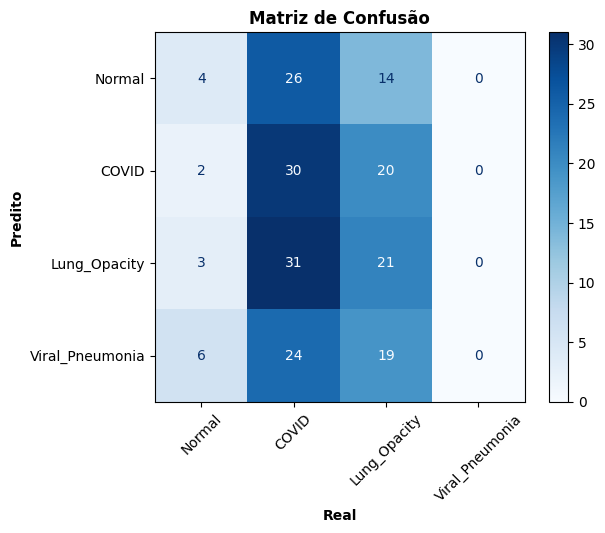

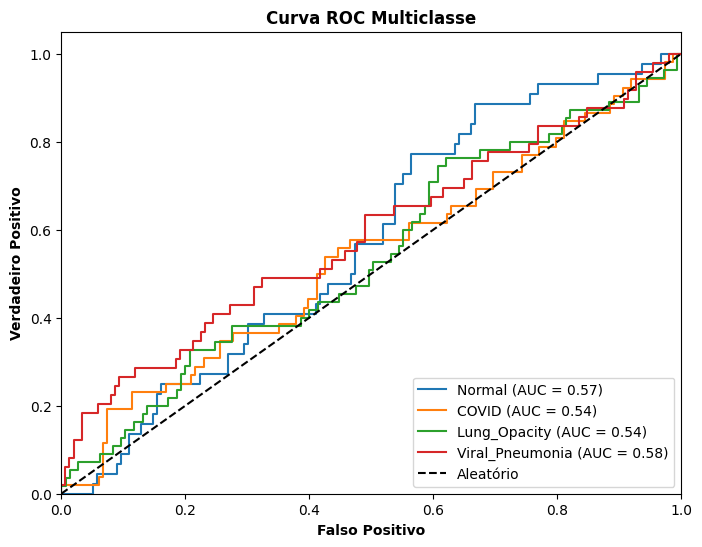

In [12]:
resnet152_pretrained = models.resnet152(weights="DEFAULT")
resnet152_pretrained.fc = nn.Linear(resnet152_pretrained.fc.in_features, N_CLASSES)
resnet152_pretrained = resnet152_pretrained.to(DEVICE)

test_dataset.set_transform(transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory = True,
    shuffle=False,
    drop_last=False,
    num_workers=N_WORKERS
)

evaluate_model(resnet152_pretrained, test_loader, TARGET_NAMES)

In [19]:
resnet152_tl = models.resnet152(weights="DEFAULT")
for param in resnet152_tl.parameters():
    param.requires_grad = False
for param in resnet152_tl.fc.parameters():
    param.requires_grad = True
resnet152_tl.fc = nn.Linear(resnet152_pretrained.fc.in_features, N_CLASSES)
resnet152_tl = resnet152_tl.to(DEVICE)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152_tl.fc.parameters(), lr=0.001)

model_path = os.path.join(MODELS_PATH, "resnet152_tl.pth")
if os.path.exists(model_path):
    load_model(resnet152_tl, model_path)
    print("Modelo carregado!")
else:
    train_dataset.set_transform(transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        pin_memory = True,
        shuffle=True,
        drop_last=False,
        num_workers=N_WORKERS
    )

    train_model(resnet152_tl, train_loader, loss_fn, optimizer, N_EPOCHS)
    save_model(resnet152_tl, model_path)
    print("Modelo treinado!")

Epoch 1/30 / Loss: 1.0700 / Acc: 0.5925
----------------------------------------
Epoch 2/30 / Loss: 0.7295 / Acc: 0.7775
----------------------------------------
Epoch 3/30 / Loss: 0.6143 / Acc: 0.8037
----------------------------------------
Epoch 4/30 / Loss: 0.5378 / Acc: 0.8313
----------------------------------------
Epoch 5/30 / Loss: 0.4723 / Acc: 0.8588
----------------------------------------
Epoch 6/30 / Loss: 0.4292 / Acc: 0.8925
----------------------------------------
Epoch 7/30 / Loss: 0.4110 / Acc: 0.8812
----------------------------------------
Epoch 8/30 / Loss: 0.3913 / Acc: 0.8875
----------------------------------------
Epoch 9/30 / Loss: 0.3478 / Acc: 0.9062
----------------------------------------
Epoch 10/30 / Loss: 0.3391 / Acc: 0.9075
----------------------------------------
Epoch 11/30 / Loss: 0.2952 / Acc: 0.9337
----------------------------------------
Epoch 12/30 / Loss: 0.2893 / Acc: 0.9375
----------------------------------------
Epoch 13/30 / Loss: 0.266

Tempo de teste: 2.18 segundos
Global F1-score: 0.8418
Global Accuracy: 0.8400
F1-score por classe: [0.76767677 0.82105263 0.80733945 0.96907216]


<Figure size 1000x600 with 0 Axes>

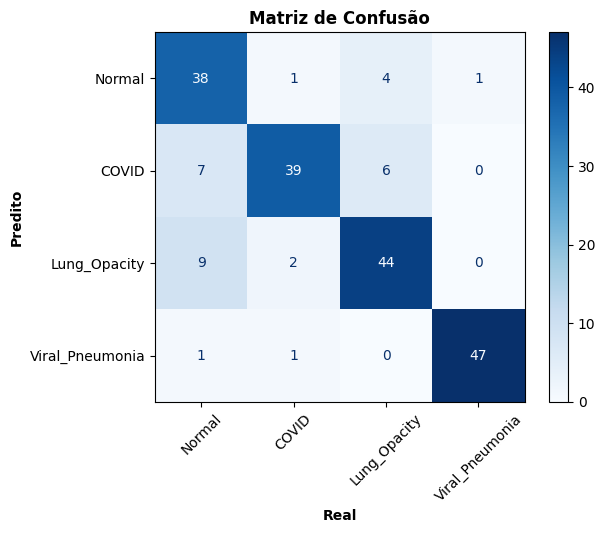

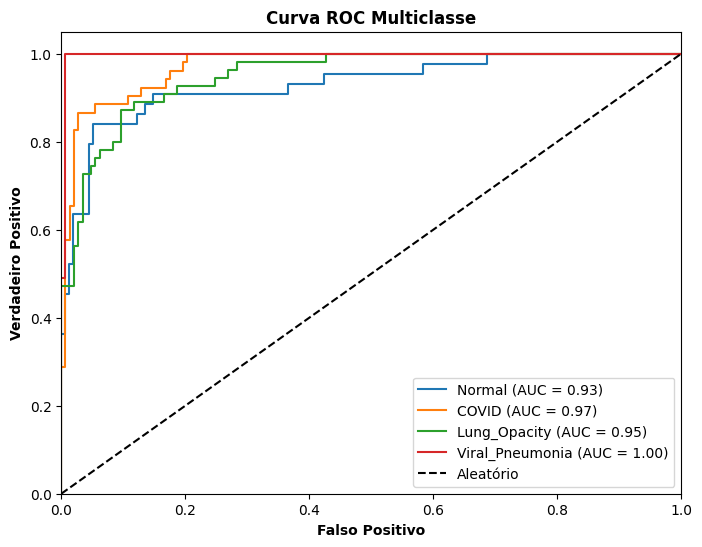

In [20]:
test_dataset.set_transform(transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory = True,
    shuffle=False,
    drop_last=False,
    num_workers=N_WORKERS
)

evaluate_model(resnet152_tl, test_loader, TARGET_NAMES)